# Split k-folds

In [1]:
import json
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
import cv2

In [2]:
raw_train_json_path = 'nafnet_train_night2day.json'
raw_test_json_path = 'nafnet_val_night2day.json'

raw_train_json = json.load(open(raw_train_json_path))
raw_test_json = json.load(open(raw_test_json_path))

## Merge json files

In [3]:
# Merge train json
image_id = 1
annotation_id = 1
total_image_info = []
total_annotation_info = []
for raw_image_info in tqdm(raw_train_json['images']):
    image_path = raw_image_info['file_name']
    image_info = {}
    image_info['id'] = image_id
    image_id += 1
    image_info['width'] = raw_image_info['width']
    image_info['height'] = raw_image_info['height']
    image_info['file_name'] = image_path
    total_image_info.append(image_info)
    # add annotation
    for raw_annotation_info in raw_train_json['annotations']:
        if raw_annotation_info['image_id'] == raw_image_info['id']:
            annotation_info = {}
            annotation_info['id'] = annotation_id
            annotation_id += 1
            annotation_info['image_id'] = image_info['id']
            annotation_info['category_id'] = raw_annotation_info['category_id']
            annotation_info['bbox'] = raw_annotation_info['bbox']
            annotation_info["segmentation"] = raw_annotation_info["segmentation"]
            annotation_info['area'] = raw_annotation_info['area']
            annotation_info['iscrowd'] = raw_annotation_info['iscrowd']
            total_annotation_info.append(annotation_info)
    # break

100%|██████████| 9/9 [00:00<00:00, 44938.97it/s]


In [4]:
# Merge test json   
for raw_image_info in tqdm(raw_test_json['images']):
    image_path = raw_image_info['file_name']
    image_info = {}
    image_info['id'] = image_id
    image_id += 1
    image_info['width'] = raw_image_info['width']
    image_info['height'] = raw_image_info['height']
    image_info['file_name'] = image_path
    total_image_info.append(image_info)
    # add annotation
    for raw_annotation_info in raw_test_json['annotations']:
        if raw_annotation_info['image_id'] == raw_image_info['id']:
            annotation_info = {}
            annotation_info['id'] = annotation_id
            annotation_id += 1
            annotation_info['image_id'] = image_info['id']
            annotation_info['category_id'] = raw_annotation_info['category_id']
            annotation_info['bbox'] = raw_annotation_info['bbox']
            annotation_info["segmentation"] = raw_annotation_info["segmentation"]
            annotation_info['area'] = raw_annotation_info['area']
            annotation_info['iscrowd'] = raw_annotation_info['iscrowd']
            total_annotation_info.append(annotation_info)
    # break

100%|██████████| 15/15 [00:00<00:00, 74279.29it/s]


In [5]:
save_json = {}
save_json['images'] = total_image_info
save_json['annotations'] = total_annotation_info
save_json['categories'] = raw_train_json['categories']

In [6]:
json_data = save_json

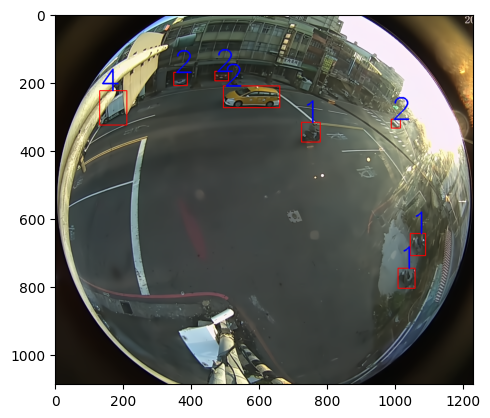

In [7]:
# VISUALIZE
image_info = random.choice(json_data['images'])
image_file_path = image_info['file_name']
image = cv2.imread(image_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# read label
image_id = image_info['id']
for annotation in json_data['annotations']:
    if annotation['image_id'] == image_id:
        # print("Found annotation")
        bbox = annotation['bbox']
        bbox = [int(x) for x in bbox]
        bbox = np.array(bbox)
        bbox = bbox.astype(np.int32)
        category_id = annotation['category_id']
        # print(category_id)
        # print(bbox)
        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255,0,0), 2)
        image = cv2.putText(image, str(category_id), (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255),4)
plt.imshow(image)
plt.show()


In [8]:
save_json['categories']

[{'id': 0, 'name': 'Bus', 'supercategory': 'root'},
 {'id': 1, 'name': 'Bike', 'supercategory': 'root'},
 {'id': 2, 'name': 'Car', 'supercategory': 'root'},
 {'id': 3, 'name': 'Pedestrian', 'supercategory': 'root'},
 {'id': 4, 'name': 'Truck', 'supercategory': 'root'}]

In [9]:
import json
with open("sample.json", "w") as train_file:
    json.dump(json_data, train_file)

# Split k-folds

In [10]:
data = save_json

In [12]:
from sklearn.model_selection import KFold
def split_dataset_with_train_test(data, k=5, test_size=0.2):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    images = data['images']
    annotations = data['annotations']
    categories = data['categories']
    image_id_to_image = {image['id']: image for image in images}
    image_id_to_annotations = {image_id: [] for image_id in image_id_to_image}
    for annotation in annotations:
        image_id_to_annotations[annotation['image_id']].append(annotation)
    folds = []
    for train_index, test_index in kf.split(images):
        train_images = [images[i] for i in train_index]
        test_images = [images[i] for i in test_index]
        train_annotations = [anno for image in train_images for anno in image_id_to_annotations[image['id']]]
        test_annotations = [anno for image in test_images for anno in image_id_to_annotations[image['id']]]
        fold = {
            'train': {
                'images': train_images,
                'annotations': train_annotations,
                'categories': categories
            },
            'test': {
                'images': test_images,
                'annotations': test_annotations,
                'categories': categories
            }
        }
        folds.append(fold)
    return folds

In [13]:
folded_data_with_train_test = split_dataset_with_train_test(data)
output_files_train_test = []
for i, fold in enumerate(folded_data_with_train_test):
    fold_file_name_train = f'./kfolds_json/kfold_{i+1}_train.json'
    fold_file_name_test = f'./kfolds_json/kfold_{i+1}_test.json'
    with open(fold_file_name_train, 'w') as file:
        json.dump(fold['train'], file, indent=4)
    with open(fold_file_name_test, 'w') as file:
        json.dump(fold['test'], file, indent=4)
    output_files_train_test.append((fold_file_name_train, fold_file_name_test))
output_files_train_test

[('./kfolds_json/kfold_1_train.json', './kfolds_json/kfold_1_test.json'),
 ('./kfolds_json/kfold_2_train.json', './kfolds_json/kfold_2_test.json'),
 ('./kfolds_json/kfold_3_train.json', './kfolds_json/kfold_3_test.json'),
 ('./kfolds_json/kfold_4_train.json', './kfolds_json/kfold_4_test.json'),
 ('./kfolds_json/kfold_5_train.json', './kfolds_json/kfold_5_test.json')]

In [14]:
check_json_path = './kfolds_json/kfold_1_train.json'
check_json = json.load(open(check_json_path))

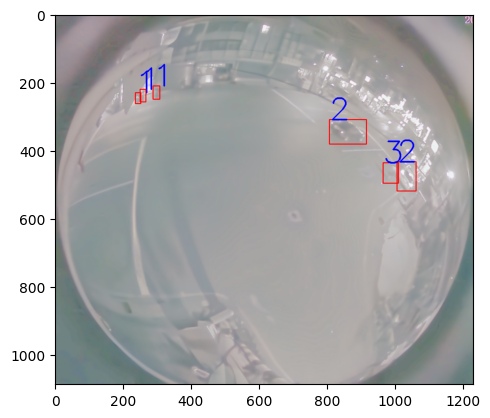

In [18]:
json_data = check_json
# VISUALIZE
image_info = random.choice(json_data['images'])
image_file_path = image_info['file_name']
image = cv2.imread(image_file_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# read label
image_id = image_info['id']
for annotation in json_data['annotations']:
    if annotation['image_id'] == image_id:
        # print("Found annotation")
        bbox = annotation['bbox']
        bbox = [int(x) for x in bbox]
        bbox = np.array(bbox)
        bbox = bbox.astype(np.int32)
        category_id = annotation['category_id']
        # print(category_id)
        # print(bbox)
        image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (255,0,0), 2)
        image = cv2.putText(image, str(category_id), (bbox[0], bbox[1]), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 0, 255),4)
plt.imshow(image)
plt.show()